In [1]:
# install modules
import scanpy as sc
import pandas as pd
import numpy as np
from plotnine import *

In [3]:
# import all ET data
ET01 = sc.read_10x_mtx(path = 'data/ET01', prefix = 'GSM3309832_ET01.')
ET02 = sc.read_10x_mtx(path = 'data/ET02', prefix = 'GSM3309833_ET02.')
ET03 = sc.read_10x_mtx(path = 'data/ET03', prefix = 'GSM3309834_ET03.')
ET04 = sc.read_10x_mtx(path = 'data/ET04', prefix = 'GSM3739217_ET04.')
ET05 = sc.read_10x_mtx(path = 'data/ET05', prefix = 'GSM3739218_ET05.')

In [4]:
# concatenate all ET data
ET = sc.AnnData.concatenate(ET01, ET02, ET03, ET04, ET05, batch_key='sample', batch_categories=['ET01', 'ET02', 'ET03', 'ET04', 'ET05'], index_unique=None, join='inner')

/var/folders/vv/c9whc99103l_yc4tfrgzz9yw0000gn/T/ipykernel_2037/2828064529.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [5]:
# add column of mitochondrial genes
ET.var["mt"] = ET.var_names.str.startswith('MT-')


In [6]:
# calculate qc metrics
sc.pp.calculate_qc_metrics(ET, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

In [7]:
# filter mitochondrial enriched cells
ET = ET[ET.obs['pct_counts_mt'] <= 10]

In [8]:
# find max count value (3 standard deviations above mean)
max = ET.obs['total_counts'].mean() + 3*ET.obs['total_counts'].std()

# filter for min at 200 and max at 3 standard deviations above mean
sc.pp.filter_cells(ET, min_counts=200)
sc.pp.filter_genes(ET, max_counts=max)
sc.pp.filter_genes(ET, min_cells = 10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not un

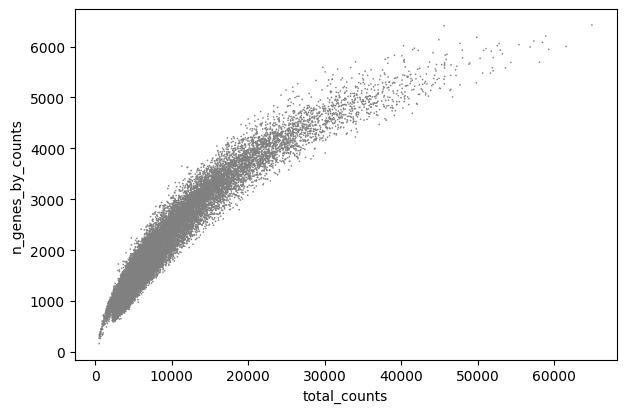

In [9]:
# plot total counts vs number of genes
sc.pl.scatter(ET, x = 'total_counts', y = 'n_genes_by_counts')

In [10]:
# filter off outliers
ET = ET[(ET.obs['total_counts'] <= 30000) & (ET.obs['n_genes_by_counts'] <= 4500)]

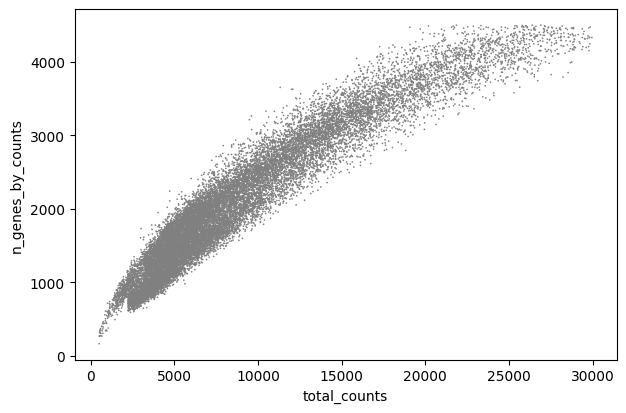

In [11]:
# replot total counts vs number of genes
sc.pl.scatter(ET, x = 'total_counts', y = 'n_genes_by_counts')

In [12]:
# run srublet for doublet detection
sc.external.pp.scrublet(ET)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_scrublet/__init__.py:286: ImplicitModificationWarning: Trying to modify attribute

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 333'. Pick better value with 'binwidth'.


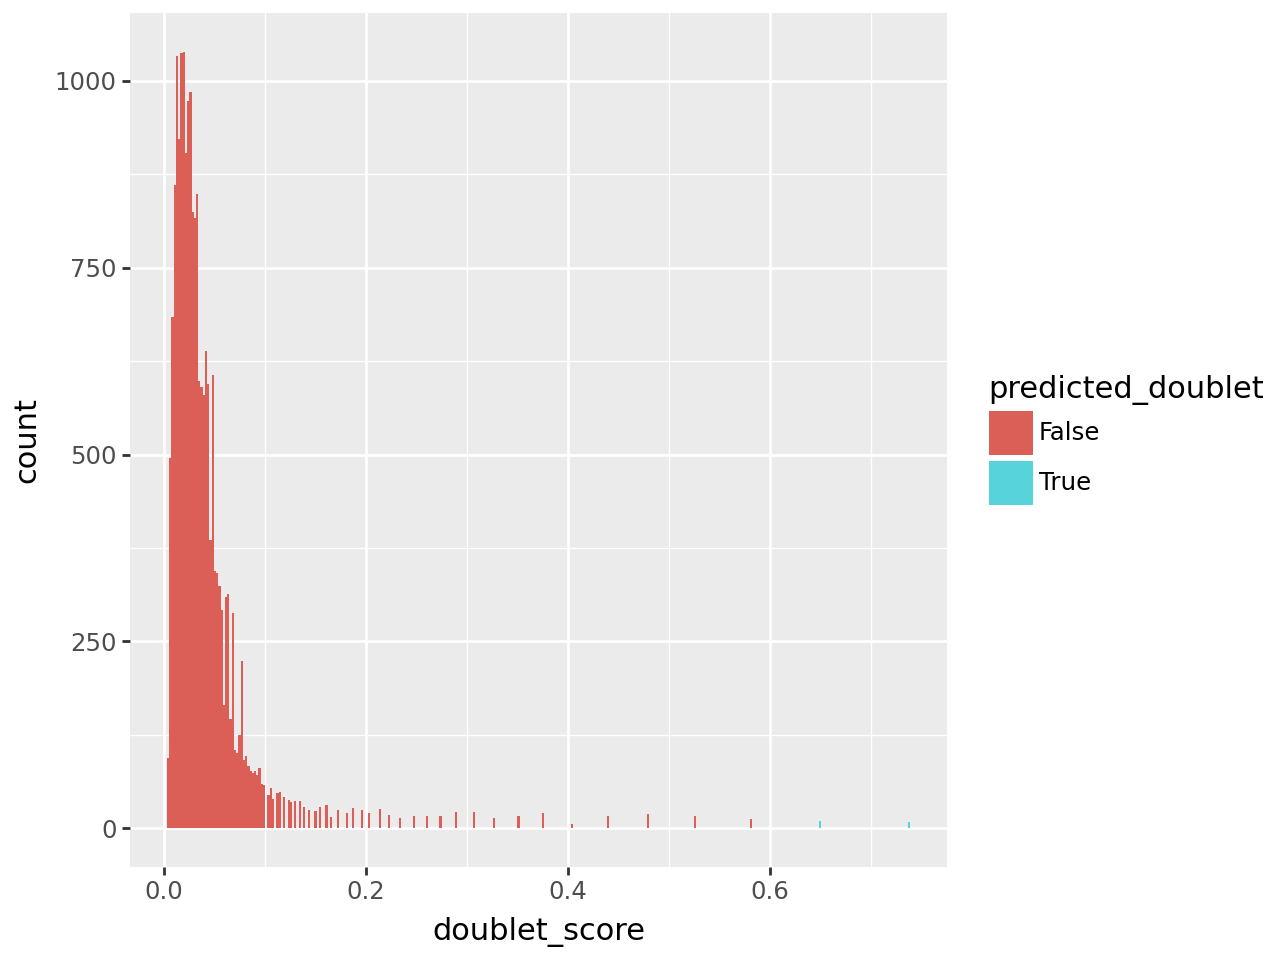

In [13]:
# doublet score histogram
ggplot(ET.obs, aes(x="doublet_score", fill = "predicted_doublet")) + geom_histogram() + geom_vline(xintercept = 0.2, color = "black")

In [14]:
# filter out doublets
ET = ET[ET.obs.doublet_score <= 0.2]

In [15]:
ET.var_names_make_unique()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [16]:
# normalize data
ET.layers["raw"] = ET.X.copy()
sc.experimental.pp.normalize_pearson_residuals(ET, theta = 0.5)

In [17]:
ET.X

array([[-0.01944631, -0.13958444, -0.02623664, ..., -0.26373804,
        -0.05041347, -0.05770286],
       [-0.01681479, -0.12128211, -0.02268802, ..., -0.23213981,
        -0.04361524, -0.04993161],
       [-0.03685549, -0.25233656, -0.04968487, ..., -0.4287908 ,
        -0.09501415, -0.10853323],
       ...,
       [-0.03119203, -0.21745063, -0.04206325, ..., -0.38334918,
        -0.08058966, -0.09212882],
       [-0.03894431, -0.2647169 , -0.052494  , ..., -0.44372657,
        -0.10030929, -0.11454502],
       [-0.02294603, -0.16348347, -0.03095464, ..., -0.30307937,
        -0.05943586, -0.06800879]], dtype=float32)

In [18]:
ET.shape

(20024, 16383)

In [19]:
# remove NaN values
ET = ET[:,(np.isnan(ET.X).sum(axis=0) == 0)]

In [20]:
# perform PCA
sc.pp.pca(ET, n_comps = 30)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


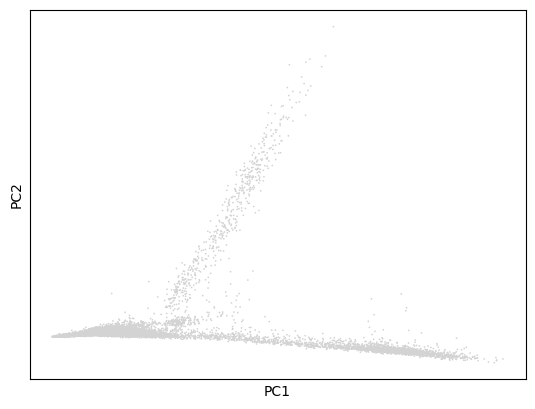

In [21]:
# plot PCA
sc.pl.pca_scatter(ET)

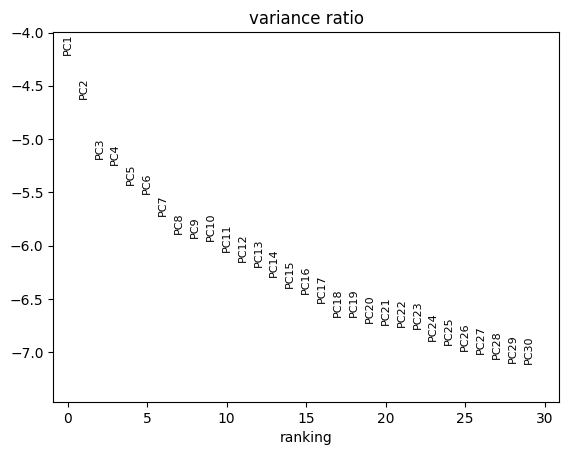

In [22]:
sc.pl.pca_variance_ratio(ET, log= True, n_pcs = 30)

In [23]:
# neighborhood graph
sc.pp.neighbors(ET, n_neighbors = 20, n_pcs = 30)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [24]:
# leiden clustering
sc.tl.leiden(ET, resolution = 0.3)

/var/folders/vv/c9whc99103l_yc4tfrgzz9yw0000gn/T/ipykernel_2037/4212847027.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [25]:
# UMAP
sc.tl.umap(ET)

In [26]:
ET.obs

sample  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGAGTAATC-1   ET01                901        3315.0             87.0   
AAACCTGAGATCGATA-1   ET01                745        2557.0             76.0   
AAACCTGAGGCTCTTA-1   ET01               2214       11595.0            361.0   
AAACCTGAGTAGGTGC-1   ET01               1628        7089.0            236.0   
AAACCTGCACATGTGT-1   ET01                946        3351.0            110.0   
...                   ...                ...           ...              ...   
TTTGGTTTCCGTCAAA-1   ET05               1865        6140.0            130.0   
TTTGGTTTCTTACACT-1   ET05               2255        6862.0            167.0   
TTTGTTGCACAAGCCC-1   ET05               1550        3851.0            202.0   
TTTGTTGCATTAAGCC-1   ET05               2143        7237.0            175.0   
TTTGTTGTCCTCTCTT-1   ET05               1037        2722.0             77.0   

                    pct_counts_mt  n_counts  doublet_score  predicted_doublet  \
AAACCTGAGAGTAATC-1       2.624434    3315.0       0.012284              False   
AAACCTGAGATCGATA-1       2.972233    2557.0       0.048697              False   
AAACCTGAGGCTCTTA-1       3.113411   11595.0       0.047748              False   
AAACCTGAGTAGGTGC-1       3.329102    7089.0       0.035261              False   
AAACCTGCACATGTGT-1       3.282602    3351.0       0.019303              False   
...                           ...       ...            ...                ...   
TTTGGTTTCCGTCAAA-1       2.117264    6140.0       0.032172              False   
TTTGGTTTCTTACACT-1       2.433693    6862.0       0.047748              False   
TTTGTTGCACAAGCCC-1       5.245391    3851.0       0.015355              False   
TTTGTTGCATTAAGCC-1       2.418129    7237.0       0.063655              False   
TTTGTTGTCCTCTCTT-1       2.828802    2722.0       0.018249              False   

                   leiden  
AAACCTGAGAGTAATC-1      4  
AAACCTGAGATCGATA-1      1  
AAACCTGAGGCTCTTA-1      1  
AAACCTGAGTAGGTGC-1      1  
AAACCTGCACATGTGT-1      1  
...                   ...  
TTTGGTTTCCGTCAAA-1      5  
TTTGGTTTCTTACACT-1      8  
TTTGTTGCACAAGCCC-1      5  
TTTGTTGCATTAAGCC-1      8  
TTTGTTGTCCTCTCTT-1     13  

[20024 rows x 9 columns]

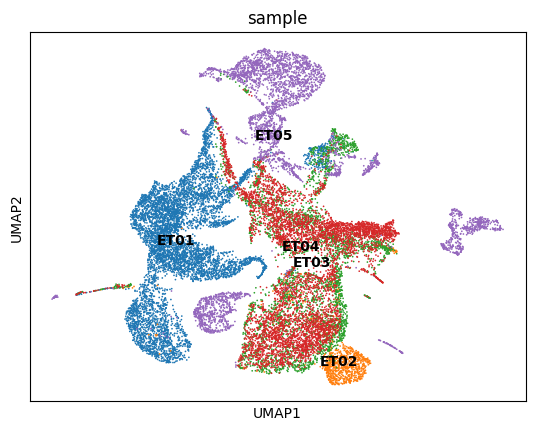

In [27]:
# plot UMAP
sc.pl.umap(ET, color = 'sample', legend_loc='on data')

In [28]:
# batch correction
sc.external.pp.harmony_integrate(ET, key = 'sample', max_iter_harmony = 20)

2024-05-05 13:07:31,043 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-05 13:07:35,482 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-05 13:07:35,598 - harmonypy - INFO - Iteration 1 of 20
2024-05-05 13:07:40,959 - harmonypy - INFO - Iteration 2 of 20
2024-05-05 13:07:46,422 - harmonypy - INFO - Iteration 3 of 20
2024-05-05 13:07:51,376 - harmonypy - INFO - Iteration 4 of 20
2024-05-05 13:07:56,753 - harmonypy - INFO - Iteration 5 of 20
2024-05-05 13:08:01,790 - harmonypy - INFO - Iteration 6 of 20
2024-05-05 13:08:06,795 - harmonypy - INFO - Iteration 7 of 20
2024-05-05 13:08:12,059 - harmonypy - INFO - Iteration 8 of 20
2024-05-05 13:08:17,186 - harmonypy - INFO - Converged after 8 iterations


In [29]:
# plot UMAP with batch correction
sc.pp.neighbors(ET, n_neighbors = 20, n_pcs = 19, use_rep = 'X_pca_harmony')

In [30]:
sc.tl.leiden(ET, resolution = 0.5)

In [31]:
sc.tl.umap(ET, min_dist = 2, spread = 10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power


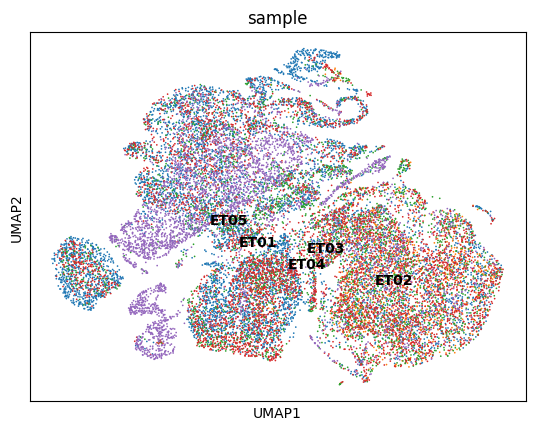

In [32]:
# plot UMAP with batch correction
sc.pl.umap(ET, color = 'sample', legend_loc='on data')

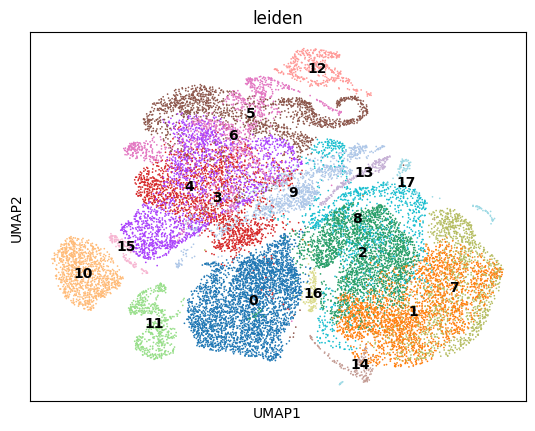

In [33]:
# batch corrected UMAP with leiden clustering
sc.pl.umap(ET, color = 'leiden', legend_loc='on data')

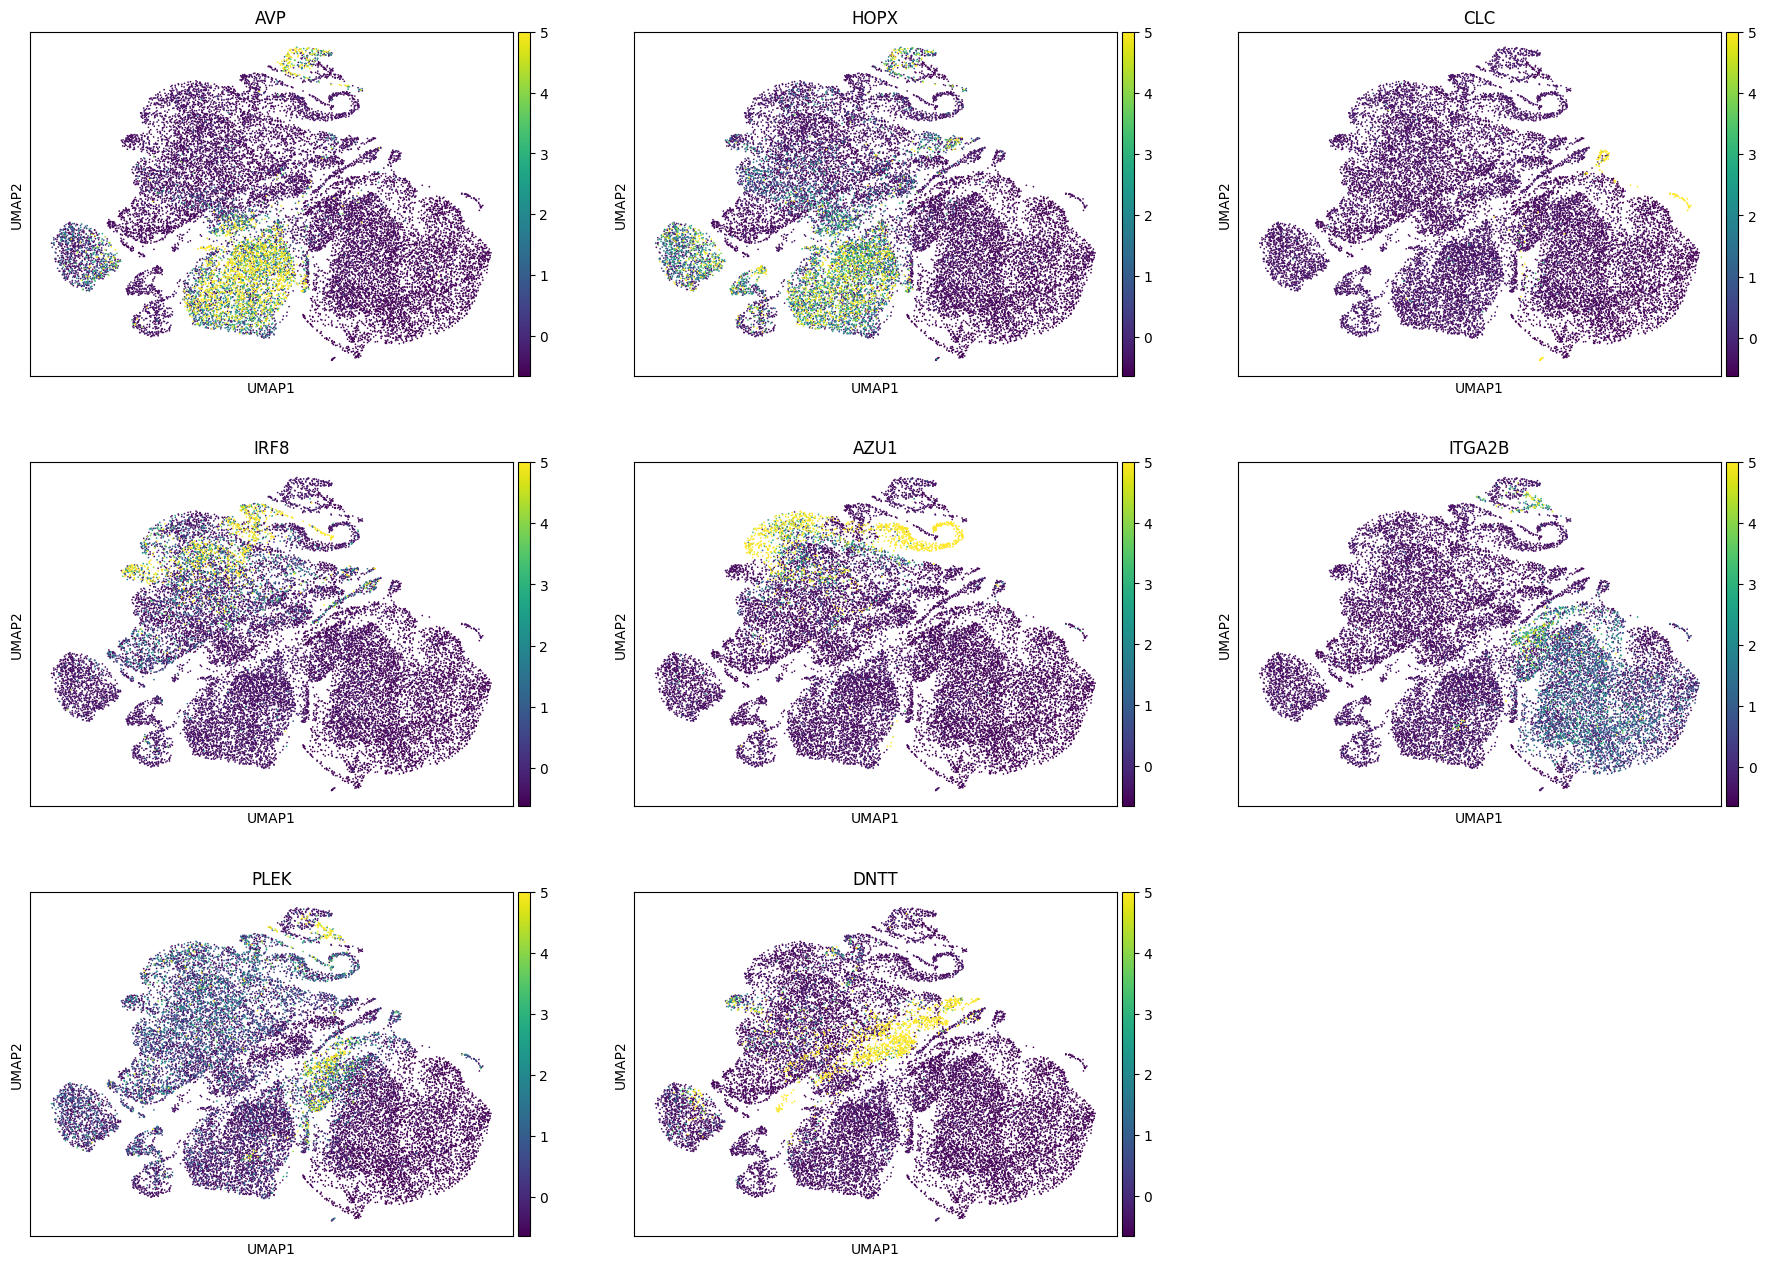

In [39]:
# marker gene expression UMAP plot
marker_genes = ['AVP', 'HOPX', 'CLC', 'IRF8', 'AZU1', 'ITGA2B',
                 'PLEK', 'DNTT']
sc.pl.umap(ET, color = marker_genes, color_map='viridis', use_raw=False, ncols=3, vmax=5)

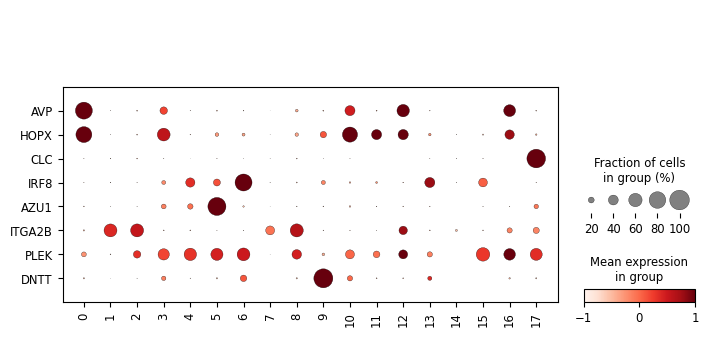

In [43]:
# dotplot of marker genes
from matplotlib.colors import Normalize
sc.pl.dotplot(ET, var_names = marker_genes, groupby = 'leiden', swap_axes = True, norm = Normalize(vmin = -1, vmax = 1))

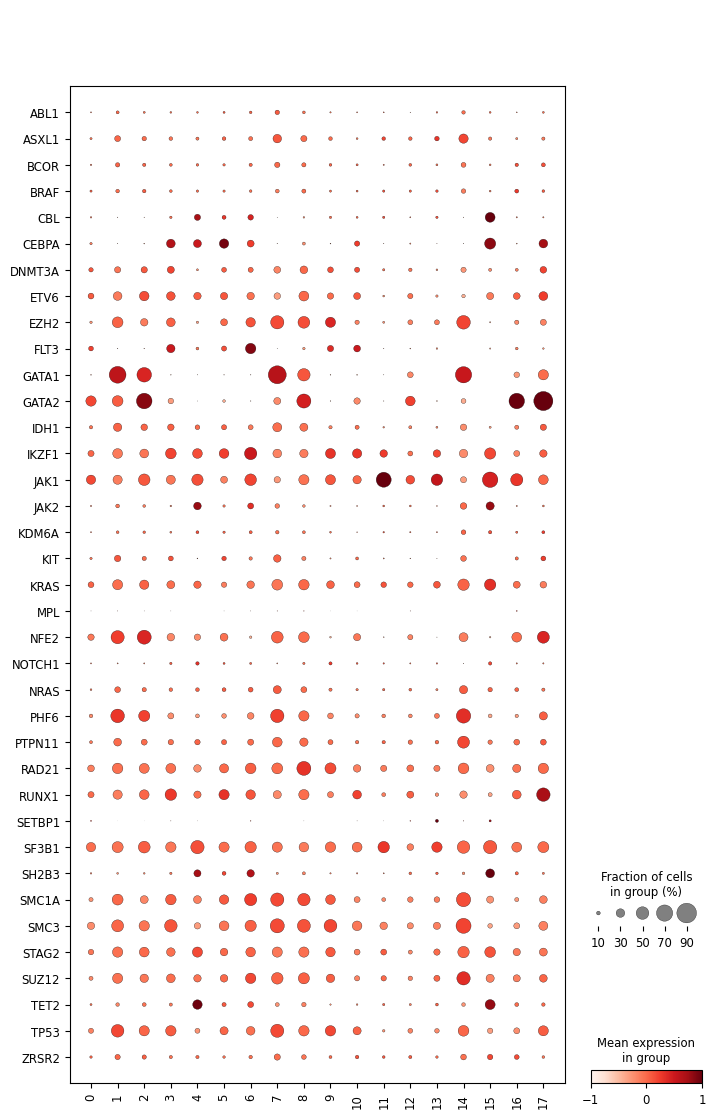

In [47]:
# dotplot of amplified genes
amplified_genes = [
    "ABL1", "ASXL1", "BCOR", "BRAF", "CBL", "CEBPA", "DNMT3A", "ETV6", "EZH2",
    "FLT3", "GATA1", "GATA2", "IDH1", "IKZF1", "JAK1", "JAK2",
    "KDM6A", "KIT", "KRAS", "MPL", "NFE2", "NOTCH1", "NRAS", "PHF6", "PTPN11",
    "RAD21", "RUNX1", "SETBP1", "SF3B1", "SH2B3", "SMC1A", "SMC3", "STAG2", "SUZ12",
    "TET2", "TP53", "ZRSR2"
]

sc.pl.dotplot(ET, var_names = amplified_genes, groupby = 'leiden', swap_axes = True, norm = Normalize(vmin = -1, vmax = 1))

In [9]:
# read in amplicon data
amp_dat = pd.read_csv('data/ET_CALR_AMPLICON/all_calls.txt', sep = '\t')

In [12]:
# mutation ratio
amp_dat['mutation_ratio'] = np.where(amp_dat['num.WT.call'] != 0, amp_dat['num.MUT.call'] / amp_dat['num.WT.call'], amp_dat['num.MUT.call'])
amp_dat

BC  num.WT.call  num.MUT.call  mutation_ratio
0      AGTTGGTAGTTCGATC           17             0        0.000000
1      GATCGATAGGAGTCTG            6             0        0.000000
2      CTCTGGTAGGTGATAT           13            10        0.769231
3      ACATGGTAGGCTCATT           25             0        0.000000
4      GACTAACTCCGAACGC           12             0        0.000000
...                 ...          ...           ...             ...
22452  TCAGCCTTCTCCGCAT            0             1        1.000000
22453  GTTACCCGTACAGAAT            1             0        0.000000
22454  TGACTCCTCCTAGCTC            0             1        1.000000
22455  AACCTTTTCATCGTAG            0             1        1.000000
22456  AACCTGACAGACGCTC            0             0        0.000000

[22457 rows x 4 columns]

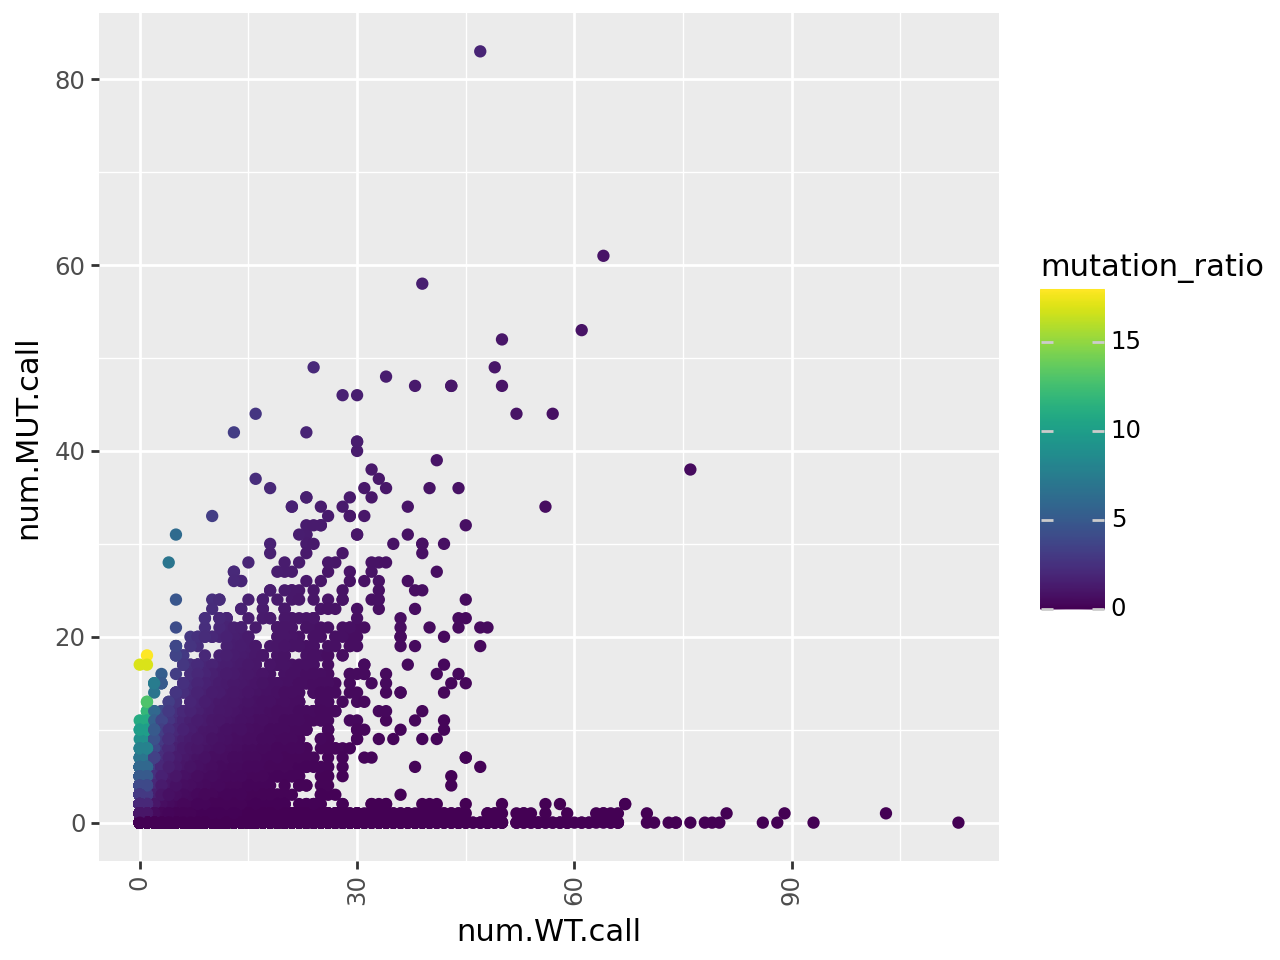

In [48]:
# plot mutation ratio
ggplot(amp_dat, aes(x = 'num.WT.call', y = 'num.MUT.call', color = 'mutation_ratio')) + geom_point() + theme(axis_text_x = element_text(angle = 90))

In [26]:
filtered_df = amp_dat[amp_dat['num.MUT.call'] != 0]

print((filtered_df['mutation_ratio'] < 1).sum())
print((filtered_df['mutation_ratio'] > 1).sum())


4490
2480


In [27]:
a1 = pd.read_csv('data/ET_CALR_AMPLICON/GSM3309838_ET01.CALR.txt', sep = '\t')
a2 = pd.read_csv('data/ET_CALR_AMPLICON/GSM3309839_ET02.CALR.txt', sep = '\t')
a3 = pd.read_csv('data/ET_CALR_AMPLICON/GSM3309840_ET03.CALR.txt', sep = '\t')
a4 = pd.read_csv('data/ET_CALR_AMPLICON/GSM3739223_ET04.CALR.txt', sep = '\t')
a5 = pd.read_csv('data/ET_CALR_AMPLICON/GSM3739224_ET05.CALR.txt', sep = '\t')

In [34]:
a1['sample'] = 'ET01'
a2['sample'] = 'ET02'
a3['sample'] = 'ET03'
a4['sample'] = 'ET04'
a5['sample'] = 'ET05'
a1['mutation_ratio'] = np.where(a1['num.WT.call'] != 0, a1['num.MUT.call'] / a1['num.WT.call'], a1['num.MUT.call'])
a2['mutation_ratio'] = np.where(a2['num.WT.call'] != 0, a2['num.MUT.call'] / a2['num.WT.call'], a2['num.MUT.call'])
a3['mutation_ratio'] = np.where(a3['num.WT.call'] != 0, a3['num.MUT.call'] / a3['num.WT.call'], a3['num.MUT.call'])
a4['mutation_ratio'] = np.where(a4['num.WT.call'] != 0, a4['num.MUT.call'] / a4['num.WT.call'], a4['num.MUT.call'])
a5['mutation_ratio'] = np.where(a5['num.WT.call'] != 0, a5['num.MUT.call'] / a5['num.WT.call'], a5['num.MUT.call'])

In [35]:
all_samples = pd.concat([a1, a2, a3, a4, a5])

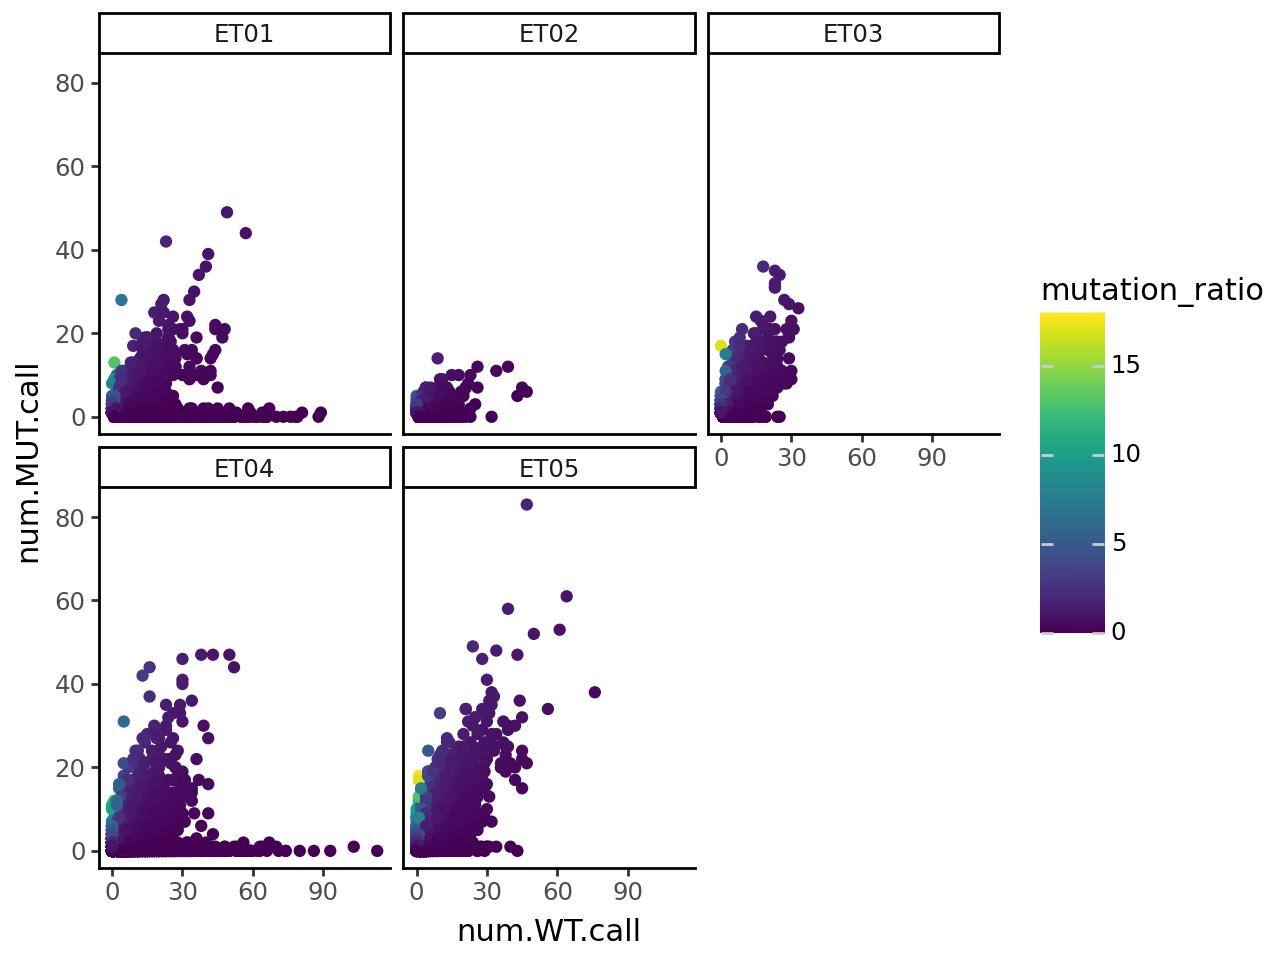

In [49]:
# mutation ratio of each sample
ggplot(all_samples, aes(x = 'num.WT.call', y = 'num.MUT.call', color = 'mutation_ratio')) + geom_point() + theme_classic() + facet_wrap('sample')

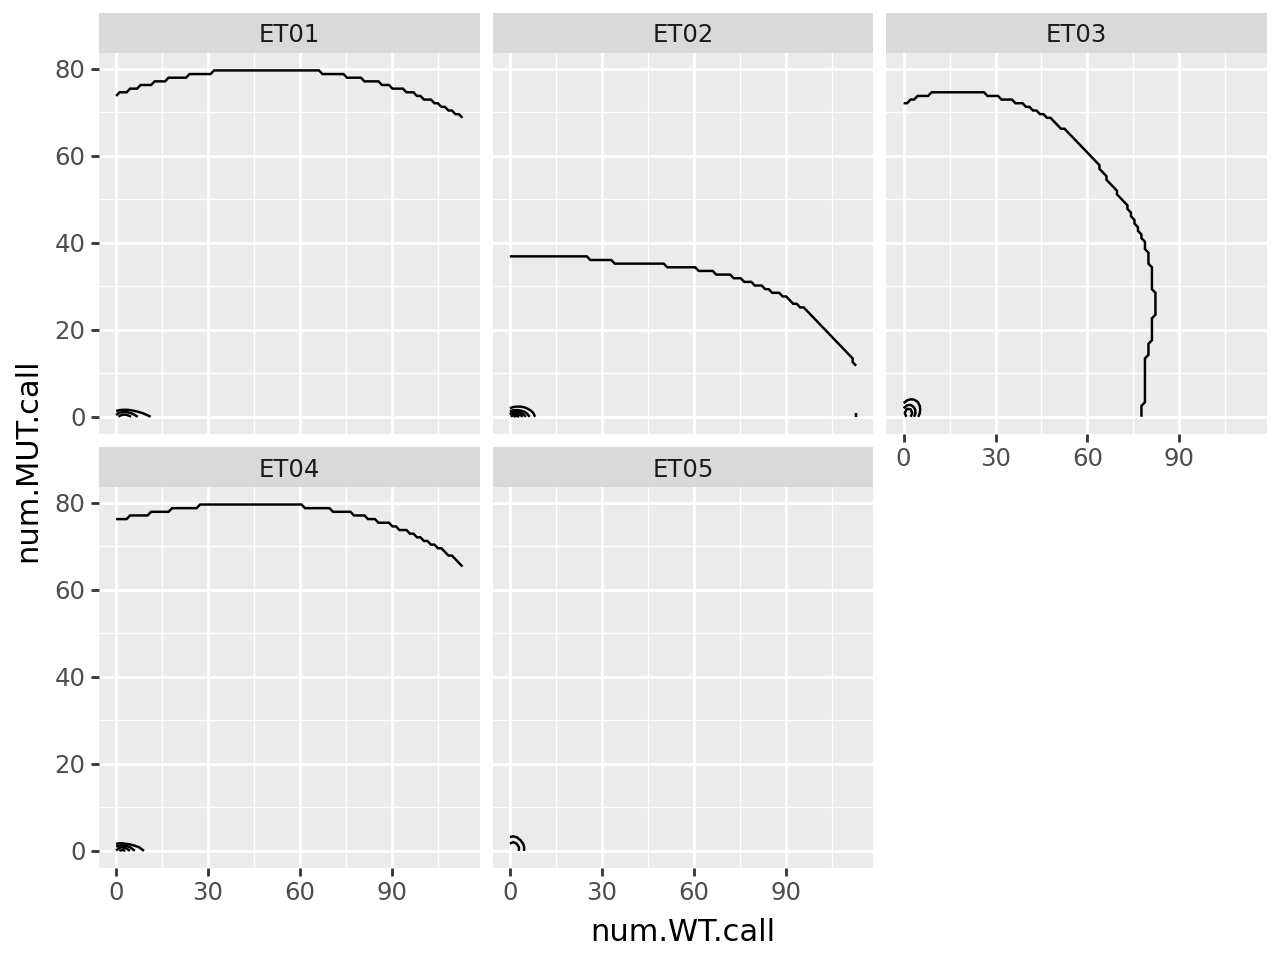

In [44]:
ggplot(all_samples, aes(x = 'num.WT.call', y = 'num.MUT.call', color = 'mutation_ratio')) + geom_density_2d(n=100) + facet_wrap('sample')